# Tumor Prediction on CAMELYON16 Dataset



In [ ]:
LOAD_SAVED_DATA = False
LEVEL_1, LEVEL_2 = 5, 2

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (57.7 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
from openslide import open_slide, __library_version__ as openslide_version

import os
import pathlib
import re
import copy

from PIL import Image
from skimage.color import rgb2gray

from random import sample 
import random
random.seed(0)

import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras import losses, metrics
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

## Utilities

### Read slides

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

### Get file paths of slides and masks

In [ ]:
def get_image_paths(path='/gdrive/My Drive/slides'):
    '''
    Args:
        path: path where slides and masks stored
    
    Returns:
        image_path: a list of slide file paths
        mask_path: a list of mask file paths
    '''
    
    image_path = [os.path.join(path, f) for f in os.listdir(path) if re.search(r'[0-9].tif', f)]
    mask_path = [os.path.join(path, f) for f in os.listdir(path) if re.search(r'[0-9]_mask.tif', f)]
    return image_path, mask_path

### Generate data from sliding window 
<a name="generate_data_from_sliding_window"></a>

In [ ]:
def generate_data_from_sliding_window(slide, mask, lev1, lev2):  
    '''
    Args:
        slide: An OpenSlide object refering to the slide
        mask: An OpenSlide object refering to the corresponding mask
        lev1: The first level (larger one: lev1 > lev2)
        lev2: The second level (smaller one: lev1 > lev2)

    Returns:
        X, y: np arrays on the sampled data and corresponding labels
        center: center coordinates of sampled data
        X2, y2: np arrays on the lev2 sampled data and corresponding labels
    '''
    
    assert lev1 >= lev2

    # read slides and masks
    slide_image_1 = read_slide(slide, 
                            x=0, 
                            y=0,
                            level=lev1, 
                            width=slide.level_dimensions[lev1][0], 
                            height=slide.level_dimensions[lev1][1])
    mask_image_1 = read_slide(mask, 
                            x=0, 
                            y=0,
                            level=lev1, 
                            width=mask.level_dimensions[lev1][0], 
                            height=mask.level_dimensions[lev1][1])
    mask_image_1 = mask_image_1[:,:,0]

    slide_image_2 = read_slide(slide, 
                            x=0, 
                            y=0,
                            level=lev2, 
                            width=slide.level_dimensions[lev2][0], 
                            height=slide.level_dimensions[lev2][1])
    mask_image_2 = read_slide(mask, 
                            x=0, 
                            y=0,
                            level=lev2, 
                            width=mask.level_dimensions[lev2][0], 
                            height=mask.level_dimensions[lev2][1])
    mask_image_2 = mask_image_2[:,:,0]

    # calculate steps and downsample factor
    step_1 = 2**lev1
    cancer_data_1 = []
    normal_data_1 = []
    
    step_2 = 2**lev2

    factor = step_1/step_2

    blur_number = 0

    sliding_window_step = 64
    if lev1 < 5:
      sliding_window_step = 128
    
    for x in range(299//2, slide_image_1.shape[0] - 299//2, sliding_window_step):
        for y in range(299//2, slide_image_1.shape[1] - 299//2, sliding_window_step):
            image_lev1 = slide_image_1[(x - 299//2):(x + 299//2), (y - 299//2):(y + 299//2), :]
            tissue_pixels = find_tissue_pixels(image_lev1)
            percent_tissue = len(tissue_pixels) / float(298 * 298) * 100
            # consider the mask for the center 128*128 regions\
            center_mask = mask_image_1[(x - 64):(x + 64), (y - 64):(y + 64)]
            if np.sum(center_mask) == 0:
                # if no mask and not background
                if percent_tissue > 10:
                    normal_data_1.append((image_lev1,0,(x, y)))
            else:
                cancer_data_1.append((image_lev1,1,(x, y)))

    cancer_images_num = len(cancer_data_1)

    print("sampled", cancer_images_num, "cancer samples")

    normal_sample_1 = sample(normal_data_1, cancer_images_num)

    for i in normal_sample_1:
        cancer_data_1.append(i)

    random.shuffle(cancer_data_1)
    X = []
    y = []
    X2 = []
    y2 = []
    center = []
    for i in cancer_data_1:
        if (i[0].shape) != (298, 298, 3):
            continue
        X.append(i[0])
        y.append(i[1])
        center.append(i[2])
        x_center = i[2][0]
        y_center = i[2][1]
        image_lev2 = slide_image_2[int(x_center * factor - 299//2):int(x_center * factor + 299//2), int(y_center * factor - 299//2):int(y_center * factor + 299//2), :]
        center_mask_lev2 = mask_image_2[int(x_center * factor - 64):int(x_center * factor + 64), int(y_center * factor - 64):int(y_center * factor + 64)]
        label_lev2 = 0
        if (np.sum(center_mask_lev2) != 0):
            label_lev2 = 1
        if label_lev2 != i[1]:
          blur_number += 1
        X2.append(image_lev2)
        y2.append(label_lev2)
    print("blur rate:" + str(100.0 * blur_number / len(X)) + "%")
    return np.array(X), np.array(y), center, np.array(X2), np.array(y2)

In [ ]:
def generate_data_from_slide_random(slide, mask, lev1, lev2):  #lev1>lev2
  slide_image_1 = read_slide(slide, 
                         x=0, 
                         y=0,
                         level=lev1, 
                         width=slide.level_dimensions[lev1][0], 
                         height=slide.level_dimensions[lev1][1])
  mask_image_1 = read_slide(mask, 
                         x=0, 
                         y=0,
                         level=lev1, 
                         width=mask.level_dimensions[lev1][0], 
                         height=mask.level_dimensions[lev1][1])
  mask_image_1 = mask_image_1[:,:,0]
  step_1 = 2**lev1
  data_1 = []

  step_2 = 2**lev2
  data_2 = []

  
  total_cancer_pixels = np.sum(mask_image_1)
  num_sample = min(500, total_cancer_pixels)
  cancer_pixels = np.argwhere(mask_image_1 == 1)
  sample_number = total_cancer_pixels
  random.shuffle(cancer_pixels)
  count_cancer = 0

  while count_cancer < sample_number and len(data_1) < num_sample:
    x = cancer_pixels[count_cancer][0]
    y = cancer_pixels[count_cancer][1]
    if (x - 299//2) < 0 or (x + 299//2) >= slide.level_dimensions[lev1][0] or (y - 299//2) < 0 or (y + 299//2) >= slide.level_dimensions[lev1][1]:
      count_cancer += 1
      continue;

    too_near = 0
    for data in data_1:
      center = data[2]
      x_center = center[0]
      y_center = center[1]
      if (x_center + step_1) >= x and (x_center - step_1) <= x and (y_center + step_1) >= y and (y_center - step_1) <= y:
        too_near = 1
        break
    if too_near == 1:
      count_cancer += 1
      continue;

    image_lev1 = slide_image_1[x - 299//2 :x + 299//2, y - 299//2:y + 299//2, :]
    tissue_pixels = find_tissue_pixels(image_lev1)
    percent_tissue = len(tissue_pixels) /  float(299 * 299) * 100
    if percent_tissue > 0.5:
      data_1.append((image_lev1,1,(x, y)))
      print("total_cancer", len(data_1))
    count_cancer += 1

  cancer_sample_num = len(data_1)

  print("sampled", cancer_sample_num,"cancer samples")
  
  normal_pixels = np.argwhere(mask_image_1 == 0)
  sample_number = slide.level_dimensions[lev1][0] * slide.level_dimensions[lev1][1] - total_cancer_pixels
  random.shuffle(normal_pixels)
  count_normal = 0
  
  print("start to sample normal images")
  while count_normal < sample_number and (len(data_1)-cancer_sample_num) < num_sample and (len(data_1)-cancer_sample_num) < cancer_sample_num:
    x = normal_pixels[count_normal][0]
    y = normal_pixels[count_normal][1]
    image_lev1 = slide_image_1[x - 299//2 :x + 299//2, y - 299//2:y + 299//2, :]
    if x - 299//2 < 0 or x + 299//2 >= slide.level_dimensions[lev1][0] or y - 299//2 < 0 or y + 299//2 >= slide.level_dimensions[lev1][1]:
      count_normal += 1
      #print(count_normal)
      continue;
    too_near = 0  # if the center is too near to the other centers in the data
    for data in data_1[cancer_sample_num:]:
      center = data[2]
      x_center = center[0]
      y_center = center[1]
      if (x_center + step_1) >= x and (x_center - step_1) <= x and (y_center + step_1) >= y and (y_center - step_1) <= y:
        too_near = 1
        break
    if too_near == 1:
      count_cancer += 1
      continue;
    tissue_pixels = find_tissue_pixels(image_lev1)
    percent_tissue = len(tissue_pixels) / float(299 * 299) * 100
    if percent_tissue > 0.3:
      data_1.append((image_lev1,0,(x, y)))
      print("normal_cancer", len(data_1) - cancer_sample_num)
    count_normal += 1

  print("sampled", len(data_1) - cancer_sample_num,"normal samples")


  random.shuffle(data_1)
  X = []
  y = []
  center = []
  for i in data_1:
    X.append(i[0])
    y.append(i[1])
    center.append(i[2])
  return np.array(X), np.array(y), center

### Plot slide and its corresponding masks

In [ ]:
def plot_images(image, mask_image, label, figsize=(20,10), add_box=True):
    '''
    Args:
        image: slide in np array format
        mask_image: mask in np array format
        label: label for the slide
        figsize: figsize for the fig, default: (20, 10)
        add_box: whether show the red box indicating the middle 128*128 region, default: True
    '''
    
    fig, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].imshow(image)
    ax[0].set_title("original graph")

    ax[1].imshow(image)
    ax[1].imshow(mask_image, cmap='jet', alpha=0.5)
    if add_box:
        ax[1].add_patch(patches.Rectangle((299//2 - 64, 299//2 - 64), 128, 128, linewidth=1, edgecolor='r', facecolor='none'))
    ax[1].set_title("graph with mask, label "+str(label)) 
    

### Generate and save training and validation data
<a name="generate_train_val_data"></a>

In [ ]:
def generate_train_val_data(train_name, val_name, level1, level2, print_sample_image=False):
    '''
    Args:
        train_name: mask file names of training data
        val_name: mask file names of validation data
        level1, level2: two levels
        print_sample_image: whether print a few images from sample; default: False

    Returns:
        X_train_lev1, X_train_lev2, y_train: training inputs of two levels and their corresponding labels
        X_val_lev1, X_val_lev2, y_val: validation inputs of two levels and their corresponding labels
    '''

    X_train_lev1 = np.array([])
    X_train_lev2 = np.array([])
    y_train = np.array([])
    X_val_lev1 = np.array([])
    X_val_lev2 = np.array([])
    y_val = np.array([])
    for name in train_name:
        image_path = "/gdrive/My Drive/slides/" + name[:9] + str(".tif")
        mask_path = "/gdrive/My Drive/slides/" + name
        slide = open_slide(image_path)
        tumor_mask = open_slide(mask_path)
        X, y, center, X2, y2 = generate_data_from_sliding_window(slide, tumor_mask, lev1=level1, lev2 = level2)
        print(X_train_lev1.shape, X.shape)
        if X_train_lev1.shape == (0,):
            X_train_lev1 = X
            X_train_lev2 = X2
            y_train = y
        else:
            X_train_lev1 = np.concatenate((X_train_lev1, X))
            X_train_lev2 = np.concatenate((X_train_lev2, X2))
            y_train = np.concatenate((y_train, y))
        if print_sample_image:
            print("print a few training images and masks from " + str(name[:9]))
            mask_image_display = read_slide(tumor_mask, 
                                x=0, 
                                y=0,
                                level=level1, 
                                width=tumor_mask.level_dimensions[level1][0], 
                                height=tumor_mask.level_dimensions[level1][1])
            mask_image_display = mask_image_display[:,:,0]

            for i in range(0,2): 
                image_0 = X[i]
                center_0 = center[i]
                mask_image_2 = mask_image_display[center_0[0] - 299//2 :center_0[0] + 299//2, center_0[1] - 299//2:center_0[1] + 299//2]
                plot_images(image_0, mask_image_2, y[i])   
        
        print("----------------------------------------------------------")
        
    
    for name in val_name:
        image_path = "/gdrive/My Drive/slides/" + name[:9] + str(".tif")
        mask_path = "/gdrive/My Drive/slides/" + name
        slide = open_slide(image_path)
        tumor_mask = open_slide(mask_path)
        X, y, center, X2, y2 = generate_data_from_sliding_window(slide, tumor_mask, lev1=level1, lev2 = level2)
        if X_val_lev1.shape == (0,):
            X_val_lev1 = X
            X_val_lev2 = X2
            y_val = y
        else:
            X_val_lev1 = np.concatenate((X_val_lev1, X))
            X_val_lev2 = np.concatenate((X_val_lev2, X2))
            y_val = np.concatenate((y_val, y))

    return X_train_lev1, X_train_lev2, y_train, X_val_lev1, X_val_lev2, y_val

In [ ]:
def save_data(X_train_lev1, X_train_lev2, y_train, X_val_lev1, X_val_lev2, y_val, saving_path='/gdrive/My Drive/applied deep learning/project'):
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)
    np.save(os.path.join(saving_path) + '/X_train_lev1.npy', X_train_lev1)
    np.save(os.path.join(saving_path) + '/X_train_lev2.npy', X_train_lev2)
    np.save(os.path.join(saving_path) + '/y_train.npy', y_train)
    np.save(os.path.join(saving_path) + '/X_val_lev1.npy', X_val_lev1)
    np.save(os.path.join(saving_path) + '/X_val_lev2.npy', X_val_lev2)
    np.save(os.path.join(saving_path) + '/y_val.npy', y_val)

### Get augument data, for the augment data part, we wrote two functions: get_augumented_data will augment the data for the 8 directions with flip based on the paper. While the get_random_augumented_data is a more time and space efficient function for mass data because it only do one random transformation of the data


In [ ]:
def get_augumented_data(X, y):    
#broadcast for np will mess up with the dimensions for the 4d array 

  X_train_lev2_rotate_1 = []
  X_train_lev2_rotate_2 = []
  X_train_lev2_rotate_3 = []
  X_train_lev2_rotate_4 = []
  X_train_lev2_rotate_5 = []
  X_train_lev2_rotate_6 = []
  X_train_lev2_rotate_7 = []
  X_train_lev2_rotate_8 = []
  X_augumented = []

  for i in X:
    X_train_rotate_1 = np.rot90(i)
    X_train_rotate_2 = np.rot90(X_train_rotate_1)
    X_train_rotate_3 = np.rot90(X_train_rotate_2)
    X_train_rotate_4 = np.rot90(X_train_rotate_3)
    X_flipped = np.fliplr(i)
    X_train_rotate_5 = np.rot90(X_flipped)
    X_train_rotate_6 = np.rot90(X_train_rotate_5)
    X_train_rotate_7 = np.rot90(X_train_rotate_6)
    X_train_rotate_8 = np.rot90(X_train_rotate_7)

    X_train_lev2_rotate_1.append(X_train_rotate_1)
    X_train_lev2_rotate_2.append(X_train_rotate_2)
    X_train_lev2_rotate_3.append(X_train_rotate_3)
    X_train_lev2_rotate_4.append(X_train_rotate_4)
    X_train_lev2_rotate_5.append(X_train_rotate_5)
    X_train_lev2_rotate_6.append(X_train_rotate_6)
    X_train_lev2_rotate_7.append(X_train_rotate_7)
    X_train_lev2_rotate_8.append(X_train_rotate_8)

  X_augumented = X_train_lev2_rotate_1 + X_train_lev2_rotate_2 + X_train_lev2_rotate_3 + X_train_lev2_rotate_4 + X_train_lev2_rotate_5 + X_train_lev2_rotate_6 + X_train_lev2_rotate_7 + X_train_lev2_rotate_8

  X_augumented = np.array(X_augumented)

  X_augumented.shape

  y_augumented = np.concatenate((y,y))
  y_augumented = np.concatenate((y_augumented,y_augumented))
  y_augumented = np.concatenate((y_augumented,y_augumented))


  return X_augumented, y_augumented


In [ ]:
def get_random_augumented_data(X_train_lev2, y_train):   
  X_train_lev2_augumented = []

  for i in X_train_lev2:

    state_0 = random.randint(0,1)
    state_1 = random.randint(0,3)

    X_aug = i
    
    if state_0 == 1:
        X_aug = np.fliplr(X_aug)
    
    if state_1 >= 1:
        X_aug = np.rot90(X_aug)

    if state_1 >= 2:
        X_aug = np.rot90(X_aug)

    if state_1 >= 3:
        X_aug = np.rot90(X_aug)

    X_train_lev2_augumented.append(X_aug)

  X_train_lev2_augumented = np.array(X_train_lev2_augumented)

  print(X_train_lev2.shape, X_train_lev2_augumented.shape)
  
  y_train_augumented = y_train

  return X_train_lev2_augumented, y_train_augumented

## Data processing, model training and evaluation

### Get slides and masks from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
image_path, mask_path = get_image_paths()
image_path.remove('/gdrive/My Drive/slides/tumor_038.tif') #tumor 38 doesn't have a mask associated 
image_path = sorted(image_path)
mask_path = sorted(mask_path)

In [ ]:
dict(zip(image_path, mask_path))

{'/gdrive/My Drive/slides/tumor_001.tif': '/gdrive/My Drive/slides/tumor_001_mask.tif',
 '/gdrive/My Drive/slides/tumor_002.tif': '/gdrive/My Drive/slides/tumor_002_mask.tif',
 '/gdrive/My Drive/slides/tumor_005.tif': '/gdrive/My Drive/slides/tumor_005_mask.tif',
 '/gdrive/My Drive/slides/tumor_012.tif': '/gdrive/My Drive/slides/tumor_012_mask.tif',
 '/gdrive/My Drive/slides/tumor_016.tif': '/gdrive/My Drive/slides/tumor_016_mask.tif',
 '/gdrive/My Drive/slides/tumor_019.tif': '/gdrive/My Drive/slides/tumor_019_mask.tif',
 '/gdrive/My Drive/slides/tumor_023.tif': '/gdrive/My Drive/slides/tumor_023_mask.tif',
 '/gdrive/My Drive/slides/tumor_031.tif': '/gdrive/My Drive/slides/tumor_031_mask.tif',
 '/gdrive/My Drive/slides/tumor_035.tif': '/gdrive/My Drive/slides/tumor_035_mask.tif',
 '/gdrive/My Drive/slides/tumor_057.tif': '/gdrive/My Drive/slides/tumor_057_mask.tif',
 '/gdrive/My Drive/slides/tumor_059.tif': '/gdrive/My Drive/slides/tumor_059_mask.tif',
 '/gdrive/My Drive/slides/tumor_

In [ ]:
mask_names = [re.search(r'tumor_[0-9]+_mask.tif', x).group(0) for x in mask_path]
mask_names

['tumor_001_mask.tif',
 'tumor_002_mask.tif',
 'tumor_005_mask.tif',
 'tumor_012_mask.tif',
 'tumor_016_mask.tif',
 'tumor_019_mask.tif',
 'tumor_023_mask.tif',
 'tumor_031_mask.tif',
 'tumor_035_mask.tif',
 'tumor_057_mask.tif',
 'tumor_059_mask.tif',
 'tumor_064_mask.tif',
 'tumor_075_mask.tif',
 'tumor_078_mask.tif',
 'tumor_081_mask.tif',
 'tumor_084_mask.tif',
 'tumor_091_mask.tif',
 'tumor_094_mask.tif',
 'tumor_096_mask.tif',
 'tumor_101_mask.tif',
 'tumor_110_mask.tif']

We have encountered a problem that if the center $128 \times 128$ has the center near the border, then if we zoom in, the center $128 \times 128$ square may not contain a tumor tissue.

We modified `generate_data` function to generate data for two levels [`generate_data_from_sliding_window`](#generate_data_from_sliding_window).


In [ ]:
slide, tumor_mask = open_slide(image_path[-5]), open_slide(mask_path[-5])
(slide, tumor_mask)

(OpenSlide('/gdrive/My Drive/slides/tumor_091.tif'),
 OpenSlide('/gdrive/My Drive/slides/tumor_091_mask.tif'))

In [ ]:
X, y, center, X2, y2 = generate_data_from_sliding_window(slide, tumor_mask, lev1=LEVEL_1, lev2=LEVEL_2)

sampled 62 cancer samples
blur rate:35.483870967741936%


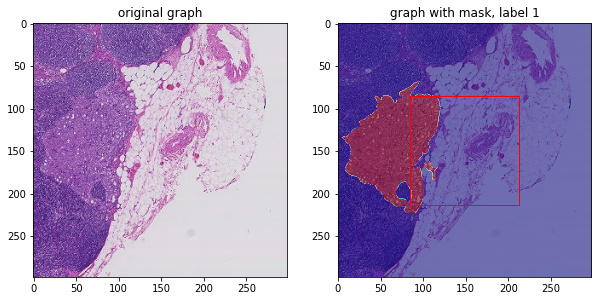

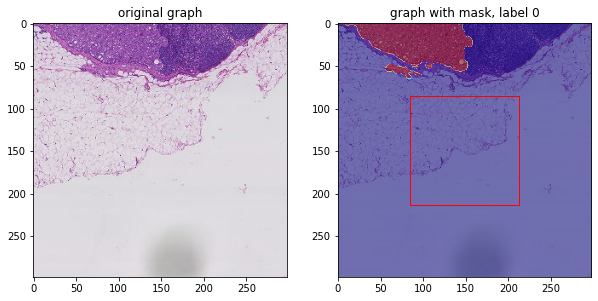

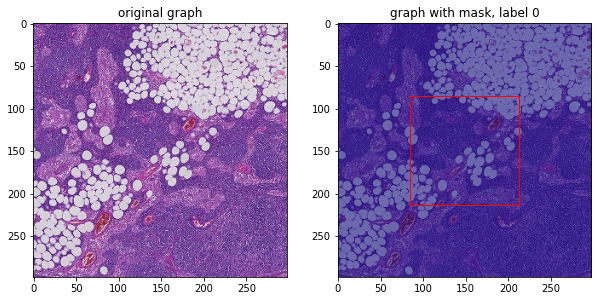

In [ ]:
mask_image_1 = read_slide(tumor_mask, 
                         x=0, 
                         y=0,
                         level=LEVEL_1, 
                         width=tumor_mask.level_dimensions[LEVEL_1][0], 
                         height=tumor_mask.level_dimensions[LEVEL_1][1])
mask_image_1 = mask_image_1[:,:,0]

for i in range(5,8): 
  image_0 = X[i]
  center_0 = center[i]
  mask_image_2 = mask_image_1[center_0[0] - 299//2 :center_0[0] + 299//2, center_0[1] - 299//2:center_0[1] + 299//2]
  plot_images(image_0, mask_image_2, y[i], figsize=(10,5))

### Training, validation and test slides( we have used a random function to get test, and val data, and we stored the results in the list just in case the random seed gets changed )

In [ ]:
test_name = ['tumor_084_mask.tif', 'tumor_031_mask.tif', 'tumor_075_mask.tif']

val_name = ['tumor_110_mask.tif', 'tumor_101_mask.tif']
train_name = []
for i in mask_names:
  if (i not in val_name and i not in test_name and i != 'tumor_059_mask.tif'):    #slide 59 has a big area of noise where they classify a few straight lines as cancer, and we discussed with the professor, he will delete the slide next year. 
    train_name.append(i)
train_name

['tumor_001_mask.tif',
 'tumor_002_mask.tif',
 'tumor_005_mask.tif',
 'tumor_012_mask.tif',
 'tumor_016_mask.tif',
 'tumor_019_mask.tif',
 'tumor_023_mask.tif',
 'tumor_035_mask.tif',
 'tumor_057_mask.tif',
 'tumor_064_mask.tif',
 'tumor_078_mask.tif',
 'tumor_081_mask.tif',
 'tumor_091_mask.tif',
 'tumor_094_mask.tif',
 'tumor_096_mask.tif']

### Get training and validation data

We implemented a function [`generate_train_val_data`](#generate_train_val_data
) to generate the training and validation sets.

In [ ]:
#LOAD_SAVED_DATA = False

if not LOAD_SAVED_DATA:
    X_train_lev1, X_train_lev2, y_train, X_val_lev1, X_val_lev2, y_val = generate_train_val_data(train_name, val_name, LEVEL_1, LEVEL_2)

sampled 25 cancer samples
blur rate:40.0%
(0,) (50, 298, 298, 3)
----------------------------------------------------------
sampled 6 cancer samples
blur rate:50.0%
(50, 298, 298, 3) (12, 298, 298, 3)
----------------------------------------------------------
sampled 9 cancer samples
blur rate:44.44444444444444%
(62, 298, 298, 3) (18, 298, 298, 3)
----------------------------------------------------------
sampled 6 cancer samples
blur rate:41.666666666666664%
(80, 298, 298, 3) (12, 298, 298, 3)
----------------------------------------------------------
sampled 97 cancer samples
blur rate:24.22680412371134%
(92, 298, 298, 3) (194, 298, 298, 3)
----------------------------------------------------------
sampled 11 cancer samples
blur rate:40.90909090909091%
(286, 298, 298, 3) (22, 298, 298, 3)
----------------------------------------------------------
sampled 20 cancer samples
blur rate:45.0%
(308, 298, 298, 3) (40, 298, 298, 3)
----------------------------------------------------------
s

In [ ]:
if not LOAD_SAVED_DATA:
    save_data(X_train_lev1, X_train_lev2, y_train, X_val_lev1, X_val_lev2, y_val)

In [ ]:
saving_path = '/gdrive/My Drive/applied deep learning/project'

X_train_lev1 = np.load(os.path.join(saving_path) + '/X_train_lev1.npy')
X_train_lev2 = np.load(os.path.join(saving_path) + '/X_train_lev2.npy')
y_train = np.load(os.path.join(saving_path) + '/y_train.npy')
X_val_lev1 =  np.load(os.path.join(saving_path) + '/X_val_lev1.npy')
X_val_lev2 =  np.load(os.path.join(saving_path) + '/X_val_lev2.npy')
y_val =  np.load(os.path.join(saving_path) + '/y_val.npy')
print(X_train_lev1.shape, X_val_lev1.shape)

(2152, 298, 298, 3) (1218, 298, 298, 3)


sanity check


In [ ]:
assert X_train_lev1.shape == X_train_lev2.shape
assert X_val_lev1.shape == X_val_lev2.shape
assert X_train_lev1.shape[0] == y_train.shape[0]
assert X_val_lev1.shape[0] == y_val.shape[0]